In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags_array, csc_array, eye_array
import scipy.sparse.linalg as sla
import pymrm as mrm
from pymrm import construct_grad, construct_div, construct_convflux_upwind, interp_cntr_to_stagg_tvd, minmod, newton

In [40]:
class ConvectionDiffusionReaction:
    def __init__(self):
        self.D = 0.1
        self.v = 1.0
        self.L = 1.0
        self.N = 100
        self.bc = {'a':[self.D,1],'b':[self.v,0], 'd':[self.v,0]}
        self.k = 0.0
        self.dt = 0.01
        self.x_f = np.linspace(0,self.L,self.N+1)
        self.x_c = 0.5*(self.x_f[0:-1]+self.x_f[1:])
        self.init_field()
        self.init_Jac()
        self.freq_out = 10
    
    def init_field(self, c0=0.0):
        self.c = np.full((self.N,),c0, dtype='float')
    
    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.x_f, self.x_c, self.bc)
        Conv, conv_bc = construct_convflux_upwind(self.c.shape, self.x_f, self.x_c, self.bc, self.v)
        self.Div = construct_div(self.c.shape, self.x_f, nu=0)   
        self.Flux = Conv - self.D * Grad
        self.flux_bc = conv_bc - self.D * grad_bc
        Jac_react = self.k*eye_array(self.N,format='csc')
        Jac_accum = (1.0/self.dt)*eye_array(self.N,format='csc')
        self.g_const = self.Div @ self.flux_bc
        self.Jac_const = Jac_accum + self.Div@self.Flux + Jac_react
            
    def construct_Jac(self, c, c_old):
        c_f , dc_f= interp_cntr_to_stagg_tvd(self.c, self.x_f, self.x_c, self.bc, self.v, minmod)
        dg_conv = self.Div @ (self.v*dc_f).reshape((-1,1))
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) + dg_conv - c_old.reshape((-1,1))/self.dt
        Jac = self.Jac_const
        return g,Jac
        
    def set_k(self, k):
        self.k = k
        Jac_accum = (1.0/self.dt)*eye_array(self.N,format='csc')
        Jac_react = self.k*eye_array(self.N,format='csc')
        self.Jac_const = Jac_accum + self.Div@self.Flux + Jac_react
             
    def solve(self, num_timesteps):
        Jac = self.Jac_const
        for i in range(num_timesteps):
            c_old = self.c.copy()        
            result = newton(lambda c: self.construct_Jac(c, c_old), c_old, maxfev=1)
            self.c = result.x
            if (i % self.freq_out == 0):
                plt.plot(self.x_c,self.c,'-o')
        plt.show()

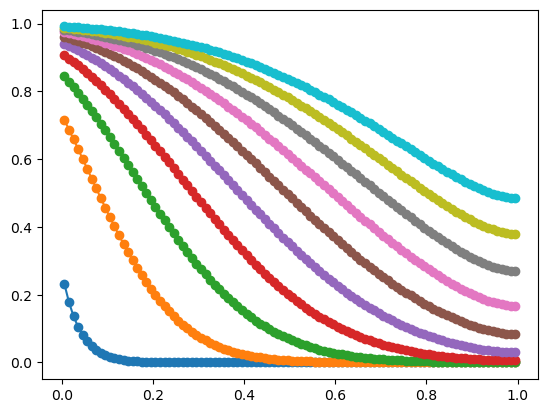

In [41]:
mrm_problem = ConvectionDiffusionReaction()
mrm_problem.init_Jac()
mrm_problem.solve(100)